# Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Config

In [29]:
pd.set_option('display.max_columns', None)

# Extração

In [184]:
file = "mundo_transfermarkt_competicoes_brasileirao_serie_a.csv"
df1 = pd.read_csv(file)
df = df1[df1['ano_campeonato'] == 2023].sort_values(by='rodada').reset_index(drop=True)
df

,ano_campeonato,data,rodada,estadio,arbitro,publico,publico_max,time_mandante,time_visitante,tecnico_mandante,tecnico_visitante,colocacao_mandante,colocacao_visitante,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante,escanteios_mandante,escanteios_visitante,faltas_mandante,faltas_visitante,chutes_bola_parada_mandante,chutes_bola_parada_visitante,defesas_mandante,defesas_visitante,impedimentos_mandante,impedimentos_visitante,chutes_mandante,chutes_visitante,chutes_fora_mandante,chutes_fora_visitante
0,2023,4/15/2023,1,Ligga Arena,Rafael Rodrigo Klein,15329.0,42372.0,Athletico-PR,Goiás,Paulo Turra,Émerson Ávila,3.0,18.0,2680.0,895.0,26.9,29.0,2.0,0.0,1.0,0.0,3.0,8.0,19.0,18.0,17.0,18.0,2.0,1.0,1.0,1.0,11.0,16.0,4.0,8.0
1,2023,4/16/2023,1,Estádio Jornalista Mário Filho,Rodrigo Jose Pereira de Lima,42848.0,78838.0,Flamengo,Coritiba FC,Mário Jorge,Toni Oliveira,2.0,19.0,7965.0,1800.0,26.5,28.3,3.0,0.0,1.0,0.0,6.0,3.0,20.0,17.0,17.0,19.0,3.0,4.0,1.0,2.0,15.0,10.0,5.0,2.0
2,2023,4/15/2023,1,Allianz Parque,Paulo Cesar Zanovelli,35835.0,NaN,Palmeiras,Cuiabá-MT,Abel Ferreira,Ivo Vieira,4.0,15.0,8420.0,593.0,26.8,29.6,2.0,1.0,1.0,1.0,4.0,4.0,23.0,12.0,12.0,21.0,3.0,3.0,3.0,2.0,17.0,12.0,7.0,6.0
3,2023,4/16/2023,1,Estádio Governador Magalhães Pinto,Raphael Claus,34980.0,57483.0,Atlético-MG,Vasco da Gama,Eduardo Coudet,Maurício Barbieri,16.0,8.0,4650.0,4970.0,28.5,25.4,1.0,2.0,1.0,2.0,14.0,3.0,15.0,10.0,9.0,15.0,1.0,9.0,2.0,2.0,26.0,7.0,7.0,1.0
4,2023,4/16/2023,1,Estádio Alfredo Jaconi,Wilton Sampaio,13997.0,23540.0,Grêmio,Santos,Renato Portaluppi,Odair Hellmann,9.0,17.0,2470.0,3880.0,28.0,26.1,1.0,0.0,1.0,0.0,4.0,11.0,12.0,16.0,15.0,12.0,4.0,5.0,1.0,1.0,17.0,16.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2023,12/7/2023,38,Arena Pantanal,Paulo Belence Alves dos Prazeres Filho,9689.0,42968.0,Cuiabá-MT,Athletico-PR,Toni Oliveira,Wesley Carvalho,12.0,8.0,923.0,2965.0,29.4,26.4,3.0,0.0,2.0,0.0,5.0,9.0,9.0,15.0,15.0,8.0,3.0,3.0,3.0,2.0,14.0,17.0,5.0,6.0
376,2023,12/7/2023,38,Estádio Urbano Caldeira,Leandro Pedro Vuaden,14130.0,20120.0,Santos,Fortaleza,Marcelo Fernandes,Juan Pablo Vojvoda,17.0,10.0,4070.0,1295.0,28.7,30.5,1.0,2.0,0.0,1.0,10.0,6.0,15.0,9.0,8.0,15.0,5.0,5.0,4.0,2.0,15.0,14.0,4.0,4.0
377,2023,12/7/2023,38,Arena Fonte Nova,Ramon Abatti,28019.0,47364.0,EC Bahia,Atlético-MG,Rogério Ceni,Luiz Felipe Scolari,16.0,3.0,2705.0,4330.0,27.6,30.4,4.0,1.0,2.0,1.0,3.0,5.0,16.0,10.0,9.0,15.0,4.0,2.0,2.0,3.0,15.0,7.0,7.0,0.0
378,2023,12/7/2023,38,Estádio Jornalista Mário Filho,Raphael Claus,44190.0,82238.0,Fluminense,Grêmio,Fernando Diniz,Renato Portaluppi,7.0,2.0,4425.0,2950.0,31.5,29.1,2.0,3.0,1.0,2.0,7.0,3.0,12.0,12.0,10.0,12.0,2.0,5.0,0.0,0.0,23.0,12.0,12.0,4.0


# Funções Auxiliares

In [94]:
def ranking_times(df, times, rodada, peso_gol_mandante=1, peso_gol_fora=1, peso_valor=0, peso_finalizacoes=0):
    pares_e_resultados = []
    df = df.fillna(0)

    for i in range(rodada*10):
        time_mandante = df.loc[i, 'time_mandante']
        time_visitante = df.loc[i, 'time_visitante']
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        resultado = ((gols_mandante*peso_gol_mandante) - (gols_visitante * peso_gol_fora)) + (peso_valor * (valor_mandante - valor_visitante)) + peso_finalizacoes*(finalizacoes_mandante-finalizacoes_visitante)        
        pares_e_resultados.append((time_mandante, time_visitante, resultado))

    num_times = len(times)
    num_equacoes = len(pares_e_resultados)
    A = np.zeros((num_equacoes, num_times))
    b = np.zeros(num_equacoes)

    for i, (time1, time2, resultado) in enumerate(pares_e_resultados):
        indice1 = times[time1]
        indice2 = times[time2]
        
        A[i, indice1] = 1    
        A[i, indice2] = -1  
        b[i] = resultado   

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

    indice_para_times = {indice: nome for nome, indice in times.items()}

    times_valores = [(indice_para_times[i], x[i]) for i in range(len(x))]

    times_valores_ordenados = sorted(times_valores, key=lambda item: item[1], reverse=True)

    return times_valores_ordenados

In [95]:
def rodadas_mmq(df, times, peso_gol_mandante=1, peso_gol_visitante=1, peso_valor=0, peso_finalizacoes=0):
    rodadas_colocacao = []
    for i in range(1,39):
        colocacao_mmq = ranking_times(df, times, i, peso_gol_mandante, peso_gol_visitante, peso_valor, peso_finalizacoes)
        rodadas_colocacao.append(colocacao_mmq)

    lista = []
    for rodada_idx, rodada_dados in enumerate(rodadas_colocacao, start=1):
        for posicao, (time, colocacao) in enumerate(rodada_dados, start=1):
            lista.append({"rodada": rodada_idx, "time": time, "colocacao": posicao})

    return pd.DataFrame(lista)

In [96]:
def plot_rodadas(time, df_original, df_mmq, rodadas):
    plt.figure(figsize=(14, 8))

    sns.lineplot(
        data=df_original[
            (df_original['rodada'] <= 38) & 
            (df_original['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='o', 
        color='black',  
        legend=None
    )

    sns.lineplot(
        data=df_mmq[
            (df_mmq['rodada'] <= 38) & 
            (df_mmq['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='^', 
        color='red',  
        legend=None
    )


    plt.title('Colocação dos Times', fontsize=16)
    plt.xlabel('Rodada', fontsize=12)
    plt.ylabel('Colocação', fontsize=12)
    plt.legend([time + ' 2023', time + ' MMQ'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    # Gerar os ticks automaticamente com base nos valores únicos da coluna rodada
    rodadas = sorted(df_original['rodada'].unique())  # Ordenar rodadas únicas
    plt.xticks(ticks=rodadas, labels=[str(r) for r in rodadas])  # Definir ticks e rótulosplt.tight_layout()
    plt.show()

In [97]:
def erro_ranking(df_original, df_mmq):
    erro_por_rodada = {}
    for rodada in range(1,39):
        # Filtrar os rankings da rodada atual
        ranking_original = (
            df_original[df_original['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )
        ranking_mmq = (
            df_mmq[df_mmq['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )

        # Garantir que ambos têm os mesmos times
        if not ranking_original.index.equals(ranking_mmq.index):
            raise ValueError(f"Os rankings das rodadas não coincidem na rodada {rodada}.")

        # Calcular a diferença entre os rankings
        diferenca = (ranking_original - ranking_mmq).abs()  # Erro absoluto
        erro_por_rodada[rodada] = diferenca.sum()  # Soma do erro absoluto

    return float(sum(erro_por_rodada.values()))

In [98]:
def erro_ranking_rodada(ranking_original, ranking, rodada):
    erro_por_rodada = {}
    ranking_original = (
        ranking_original[ranking_original['rodada'] == rodada]
        .set_index('time')['colocacao']
        .sort_index()  # Ordenar pelo nome do time
    )
    ranking_mmq = (
        ranking[ranking['rodada'] == rodada]
        .set_index('time')['colocacao']
        .sort_index()  # Ordenar pelo nome do time
    )

    # Garantir que ambos têm os mesmos times
    if not ranking_original.index.equals(ranking_mmq.index):
        raise ValueError(f"Os rankings das rodadas não coincidem na rodada {rodada}.")

    # Calcular a diferença entre os rankings
    diferenca = (ranking_original - ranking_mmq).abs()  # Erro absoluto
    erro_por_rodada[rodada] = diferenca.sum()  # Soma do erro absoluto

    return float(sum(erro_por_rodada.values()))

# Main

In [104]:
times = {
    "Athletico-PR": 0,
    "Goiás": 1,
    "Grêmio": 2,
    "Santos": 3,
    "Flamengo": 4,
    "Coritiba FC": 5,
    "Palmeiras": 6,
    "Cuiabá-MT": 7,
    "Corinthians": 8,
    "Cruzeiro": 9,
    "Botafogo": 10,
    "São Paulo": 11,
    "RB Bragantino": 12,
    "EC Bahia": 13,
    "Fortaleza": 14,
    "Internacional": 15,
    "Atlético-MG": 16,
    "Vasco da Gama": 17,
    "América-MG": 18,
    "Fluminense": 19
}

times_valores_ordenados = ranking_times(df, times, 38)

print("Times ordenados pelos valores de x:")
for time, valor in times_valores_ordenados:
    print(f"{time}: {valor:.2f}")

Times ordenados pelos valores de x:
Palmeiras: 0.78
Botafogo: 0.53
Atlético-MG: 0.50
RB Bragantino: 0.35
Flamengo: 0.35
Athletico-PR: 0.20
Grêmio: 0.17
Fluminense: 0.10
Cruzeiro: 0.07
São Paulo: 0.05
Cuiabá-MT: 0.03
Internacional: 0.02
Fortaleza: 0.02
Corinthians: -0.02
EC Bahia: -0.08
Vasco da Gama: -0.25
Goiás: -0.43
Santos: -0.62
Coritiba FC: -0.80
América-MG: -0.97


In [170]:
df_mandantes = df[['rodada', 'time_mandante', 'colocacao_mandante']].rename(
    columns={'time_mandante': 'time', 'colocacao_mandante': 'colocacao'}
)
df_visitantes = df[['rodada', 'time_visitante', 'colocacao_visitante']].rename(
    columns={'time_visitante': 'time', 'colocacao_visitante': 'colocacao'}
)
df_ranking = pd.concat([df_mandantes, df_visitantes], ignore_index=True)
df_ranking = df_ranking.sort_values(by=['rodada', 'colocacao']).reset_index(drop=True)
df_ranking

,rodada,time,colocacao
0,1,Fluminense,1.0
1,1,Flamengo,2.0
2,1,Athletico-PR,3.0
3,1,Palmeiras,4.0
4,1,RB Bragantino,5.0
...,...,...,...
755,38,EC Bahia,16.0
756,38,Santos,17.0
757,38,Goiás,18.0
758,38,Coritiba FC,19.0


Muito ruim de visualizar o plot abaixo

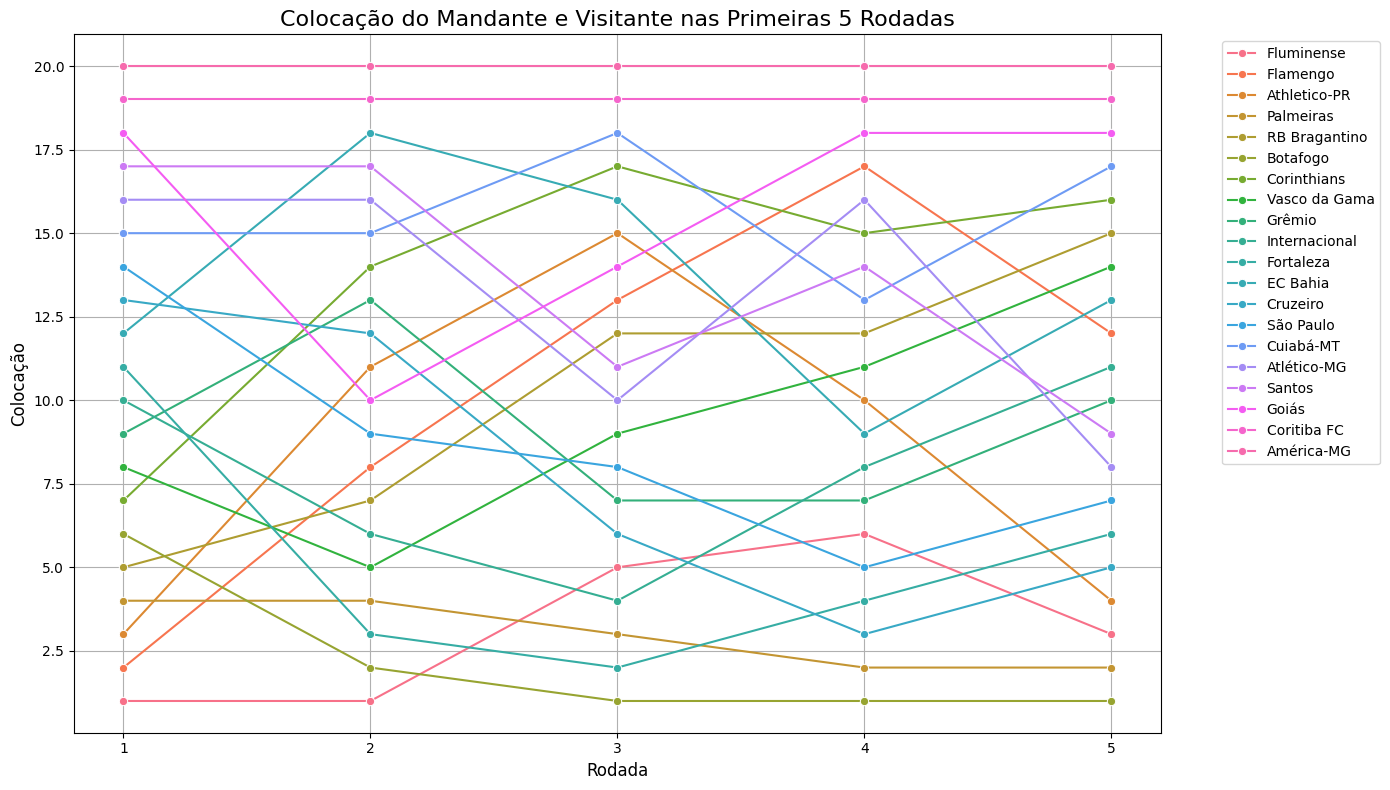

In [40]:
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=df_ranking[df_ranking['rodada'] <= 5], 
    x='rodada', 
    y='colocacao', 
    hue='time', 
    marker='o', 
    legend='brief', 
)

plt.title('Colocação do Mandante e Visitante nas Primeiras 5 Rodadas', fontsize=16)
plt.xlabel('Rodada', fontsize=12)
plt.ylabel('Colocação', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])
plt.tight_layout() 
plt.show()
# MUITO RUIM DE VISUALIZAR

Melhor visualizacao mas falta comparar com o ranking real

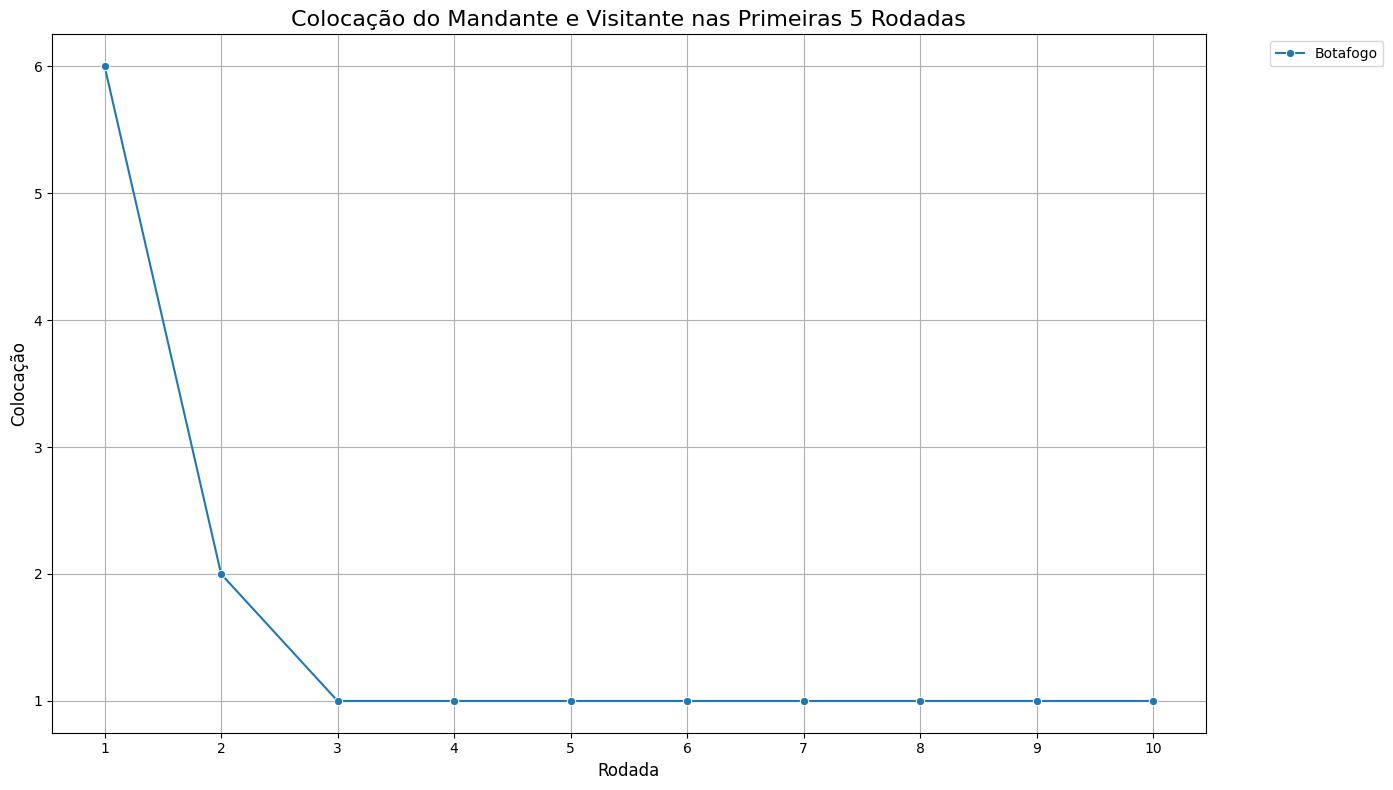

In [41]:
plt.figure(figsize=(14, 8))

sns.lineplot(
    data = df_ranking[
    (df_ranking['rodada'] <= 10) & 
    (df_ranking['time'].isin(['Botafogo']))
    ],
    x='rodada', 
    y='colocacao', 
    hue='time', 
    marker='o', 
    legend='brief', 
)

plt.title('Colocação do Mandante e Visitante nas Primeiras 5 Rodadas', fontsize=16)
plt.xlabel('Rodada', fontsize=12)
plt.ylabel('Colocação', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=['1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.tight_layout() 
plt.show()

In [ ]:
df_ranking_mmq = rodadas_mmq(df,times)
display(df_ranking_mmq[df_ranking_mmq['rodada'] == 38])

,rodada,time,colocacao
740,38,Palmeiras,1
741,38,Botafogo,2
742,38,Atlético-MG,3
743,38,RB Bragantino,4
744,38,Flamengo,5
745,38,Athletico-PR,6
746,38,Grêmio,7
747,38,Fluminense,8
748,38,Cruzeiro,9
749,38,São Paulo,10


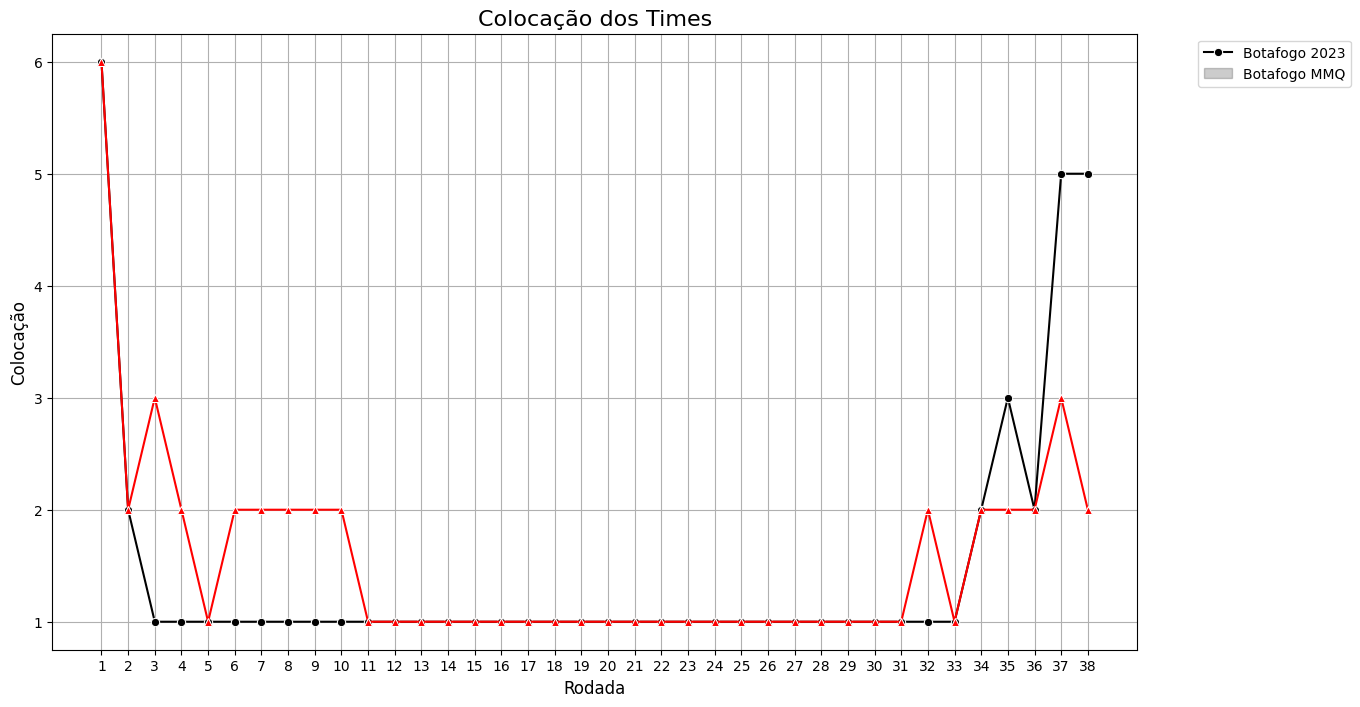

In [44]:
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq, 38)

## Escolhendo o peso para gols fora

In [14]:
df_peso_gol_fora = rodadas_mmq(df, times, 1.112)
# plot_rodadas("Fluminense", df_ranking, df_peso_gol_fora, 38)
# plot_rodadas("Fluminense", df_ranking, df_ranking_mmq,38)

In [15]:
erro_ranking(df_ranking, df_peso_gol_fora)

1226.0

In [16]:
erro_ranking(df_ranking,df_ranking_mmq)

1216.0

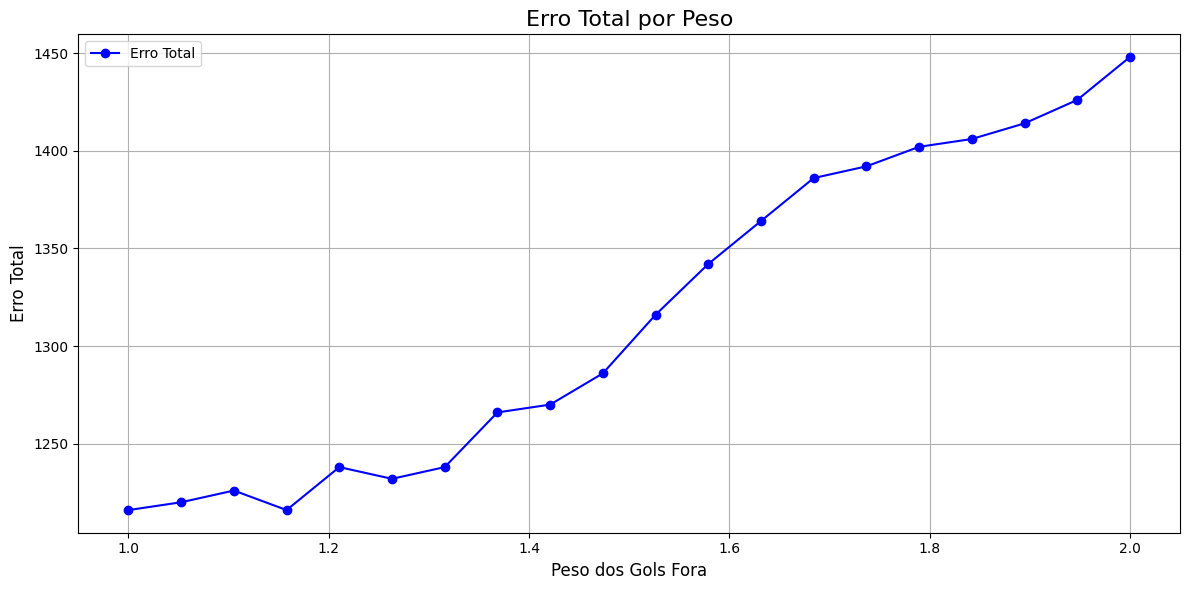

Melhor Peso: 1.0, Menor Erro: 1216.0


In [17]:
# Geração de pesos para testar
pesos = np.linspace(1, 2.0, 20)  # Pesos entre 0.5 e 2.0

erros = []
menor_erro = float('inf')  # Inicializar com infinito
melhor_peso = None         # Inicializar o melhor peso como None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_gol = peso

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

# Configurações do gráfico
plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_gol}, Menor Erro: {menor_erro}")

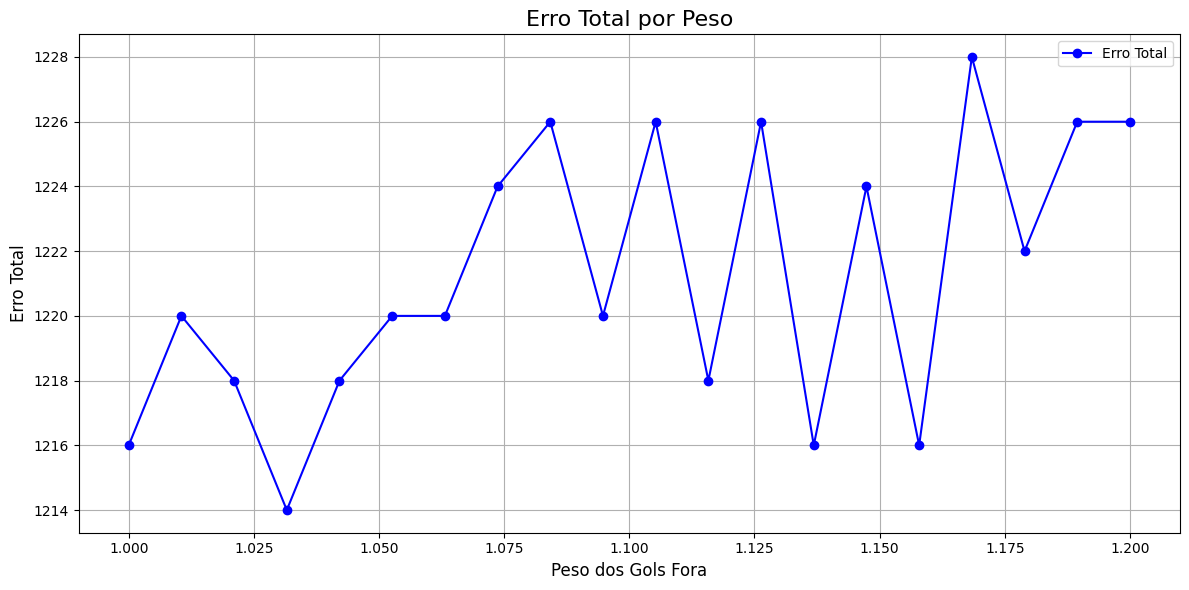

Melhor Peso: 1.0315789473684212, Menor Erro: 1214.0


In [18]:
# Geração de pesos para testar
pesos = np.linspace(1, 1.2, 20)  # Pesos entre 0.5 e 2.0

erros = []
menor_erro = float('inf')  # Inicializar com infinito
melhor_peso = None         # Inicializar o melhor peso como None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_gol = peso

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

# Configurações do gráfico
plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_gol}, Menor Erro: {menor_erro}")

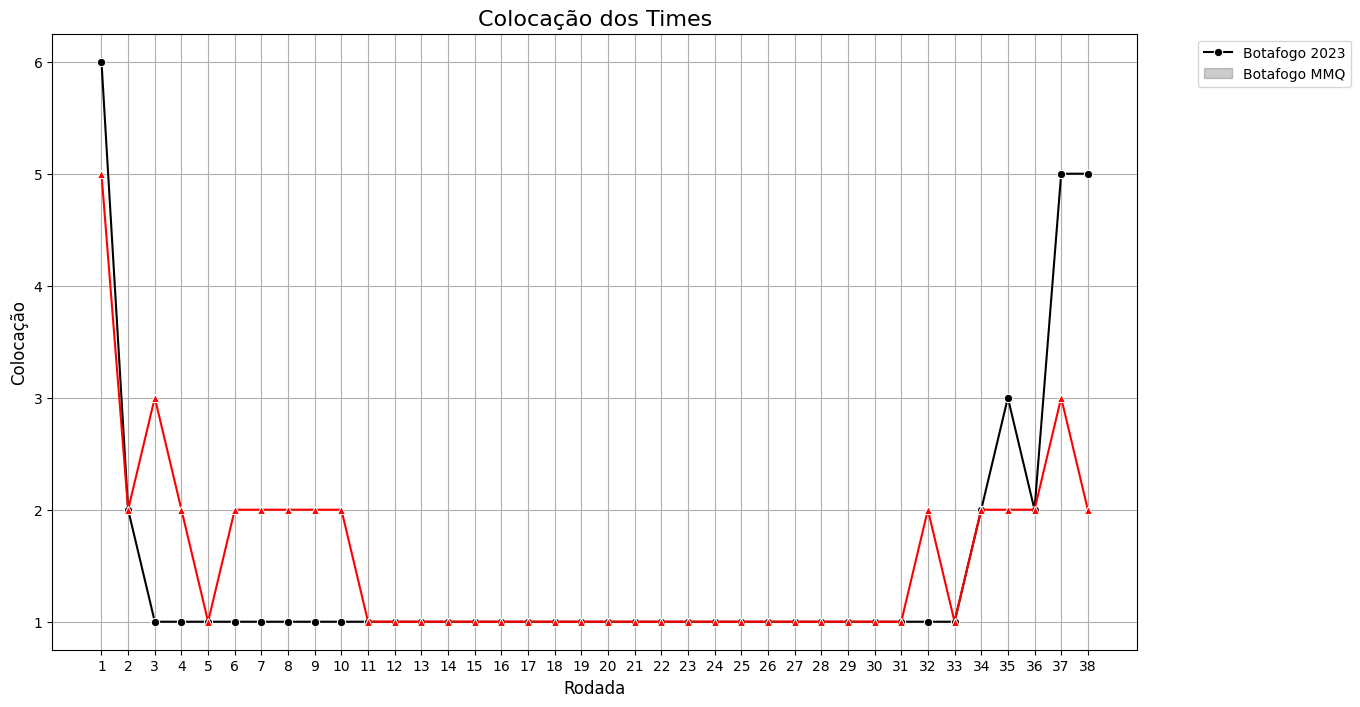

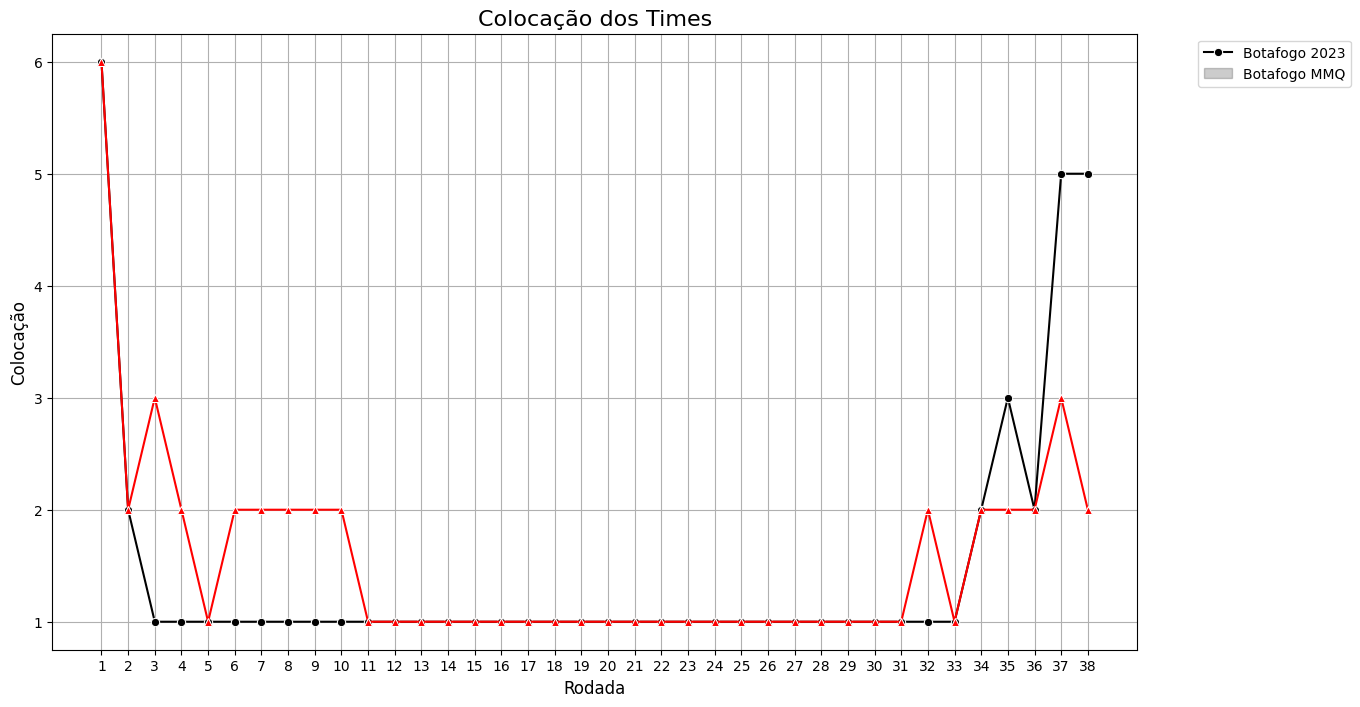

In [19]:
df_peso_gol_fora = rodadas_mmq(df, times, melhor_peso_gol)
plot_rodadas("Botafogo", df_ranking, df_peso_gol_fora,38)
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq,38)

## Valor da equipe nao ajuda

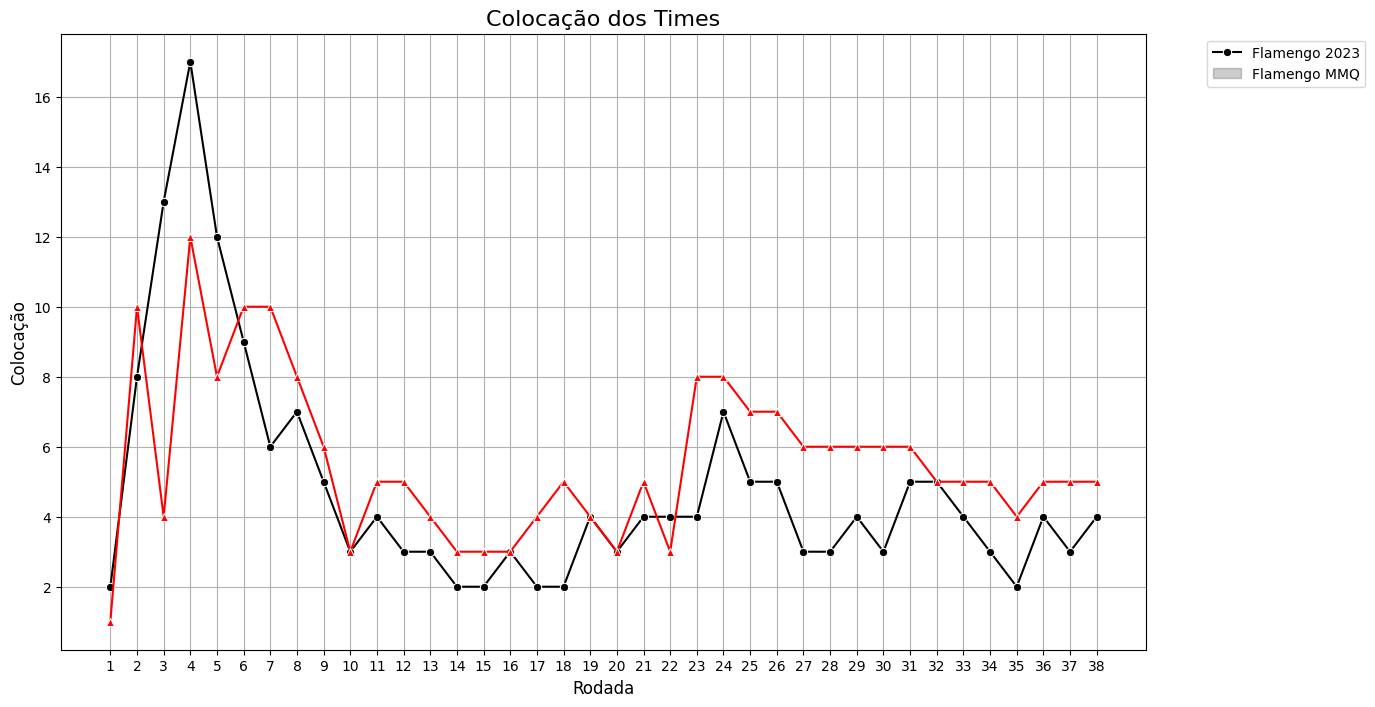

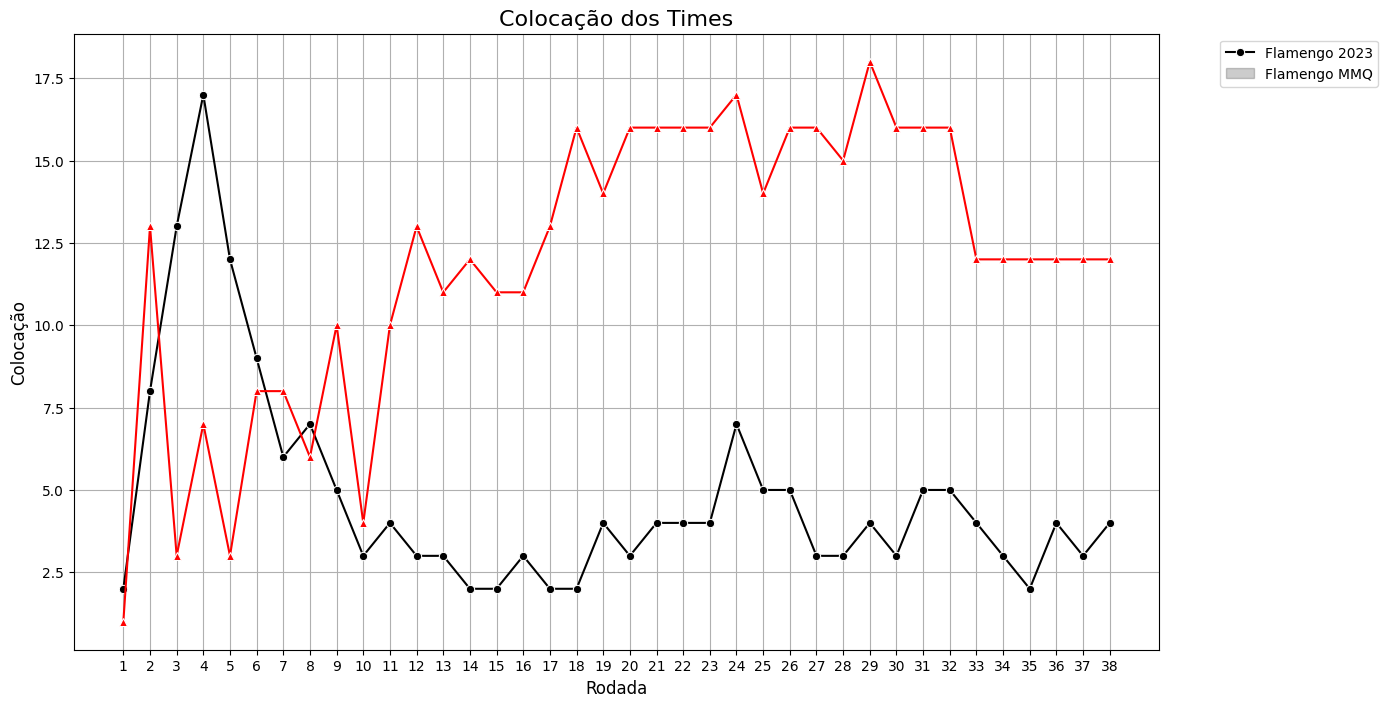

In [20]:
df_peso_valor = rodadas_mmq(df, times, melhor_peso_gol, 0.00001)
plot_rodadas("Flamengo", df_ranking, df_peso_gol_fora, 38)
plot_rodadas("Flamengo", df_ranking, df_peso_valor, 38)

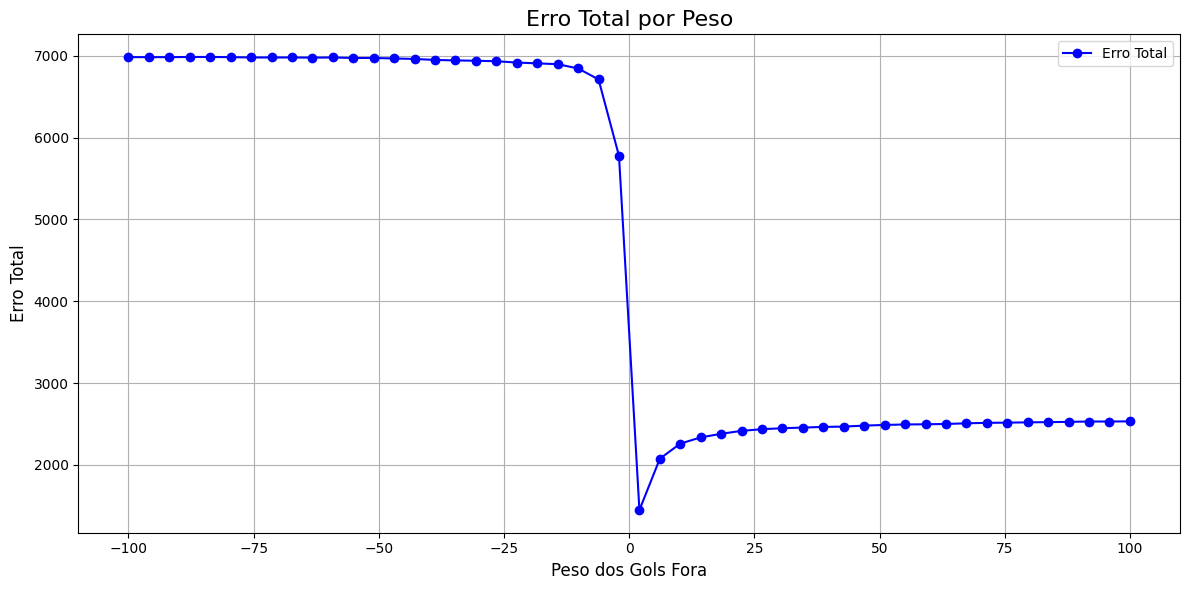

Melhor Peso: 2.040816326530617, Menor Erro: 1448.0


In [21]:
pesos = np.linspace(-100, 100, 50) 

erros = []
menor_erro = float('inf')
melhor_peso_valor = None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, melhor_peso_gol, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_valor = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_valor}, Menor Erro: {menor_erro}")

## Peso para finalizacoes

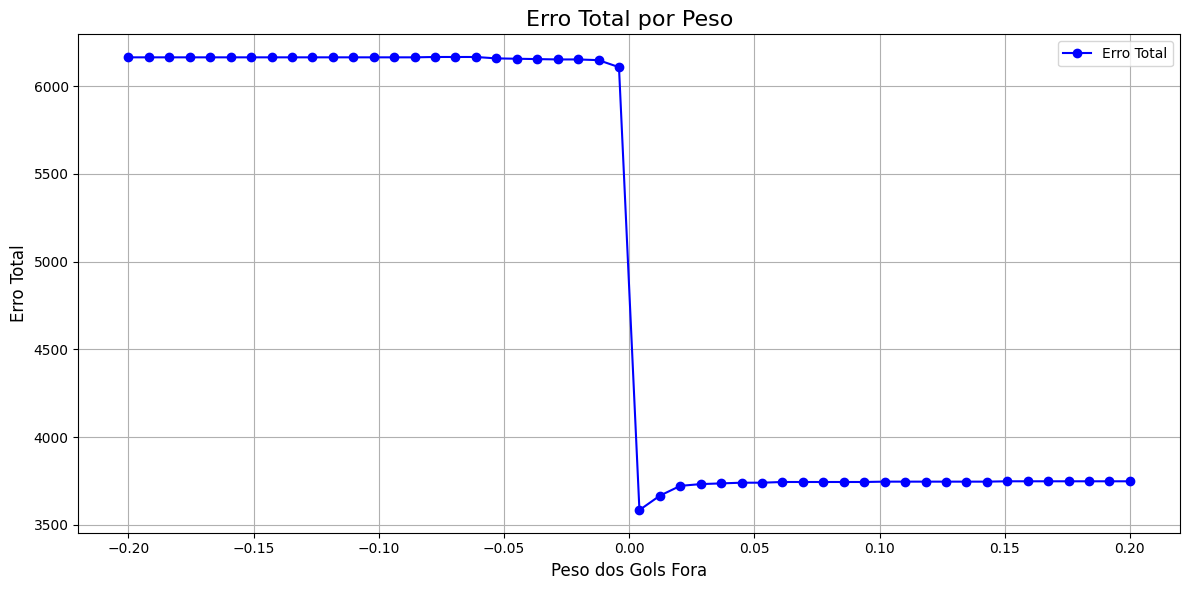

Melhor Peso: 0.004081632653061218, Menor Erro: 3584.0


In [22]:
pesos = np.linspace(-0.2, 0.2, 50) 

erros = []
menor_erro = float('inf')
melhor_peso_valor = None        

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, melhor_peso_gol,0, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_finalizacao = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_finalizacao}, Menor Erro: {menor_erro}")

## Regressao para achar os coeficientes (pesos) para valor e finalizacoes

In [ ]:
# a*(gols_mandantes) + b*(gols_visitante) + c*(finalizacao_mandante) + d*(finalizacao_visitante) + e*(valor_mandante) + f*(valor_visitante) = b

In [ ]:
def pesos_regressao(df, rodada):
    diferencas = []

    for i in range(rodada*10):
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        if gols_mandante - gols_visitante > 0:
            resultado = 3
        elif gols_mandante - gols_visitante < 0:
            resultado = 0
        else:
            resultado = 1

        if pd.isnull(gols_mandante) or pd.isnull(gols_visitante) or \
           pd.isnull(valor_mandante) or pd.isnull(valor_visitante) or \
           pd.isnull(finalizacoes_mandante) or pd.isnull(finalizacoes_visitante):
            print(f"Pulando linha {i} devido a valores nulos")
            continue
        diferencas.append((gols_mandante,gols_visitante, valor_mandante-valor_visitante, finalizacoes_mandante-finalizacoes_visitante, resultado))

    num_equacoes = len(diferencas)
    A = np.zeros((num_equacoes, 4))
    b = np.zeros(num_equacoes)
    

    for i, (gols_mandante, gols_visitante, valores, finalizacoes, resultado) in enumerate(diferencas):        
        A[i, 0] = gols_mandante
        A[i, 1] = gols_visitante
        A[i, 2] = valores
        A[i, 3] = finalizacoes
        b[i] = resultado

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

    return A, x, b

In [62]:
A, x, b = pesos_regressao(df,38)
x

Pulando linha 150 devido a valores nulos
Pulando linha 151 devido a valores nulos


array([-1.68635854e+00,  2.18502019e+00, -1.14933544e-03, -8.26990309e-02])

In [132]:
print(erro_ranking_rodada(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3]), 38))
print(erro_ranking_rodada(df_ranking, df_ranking_mmq,38))

28.0
32.0


In [48]:
display(df_ranking[df_ranking['rodada'] == 38])
df_aux = rodadas_mmq(df, times, x[0],x[1], x[2], x[3])
display(df_ranking_mmq[df_ranking_mmq['rodada'] == 38])
display(df_aux[df_aux['rodada'] == 38])

,rodada,time,colocacao
740,38,Palmeiras,1.0
741,38,Grêmio,2.0
742,38,Atlético-MG,3.0
743,38,Flamengo,4.0
744,38,Botafogo,5.0
745,38,RB Bragantino,6.0
746,38,Fluminense,7.0
747,38,Athletico-PR,8.0
748,38,Internacional,9.0
749,38,Fortaleza,10.0


,rodada,time,colocacao
740,38,Palmeiras,1
741,38,Botafogo,2
742,38,Atlético-MG,3
743,38,RB Bragantino,4
744,38,Flamengo,5
745,38,Athletico-PR,6
746,38,Grêmio,7
747,38,Fluminense,8
748,38,Cruzeiro,9
749,38,São Paulo,10


,rodada,time,colocacao
740,38,Internacional,1
741,38,Athletico-PR,2
742,38,Botafogo,3
743,38,Atlético-MG,4
744,38,Corinthians,5
745,38,Palmeiras,6
746,38,Flamengo,7
747,38,Fluminense,8
748,38,Cuiabá-MT,9
749,38,São Paulo,10


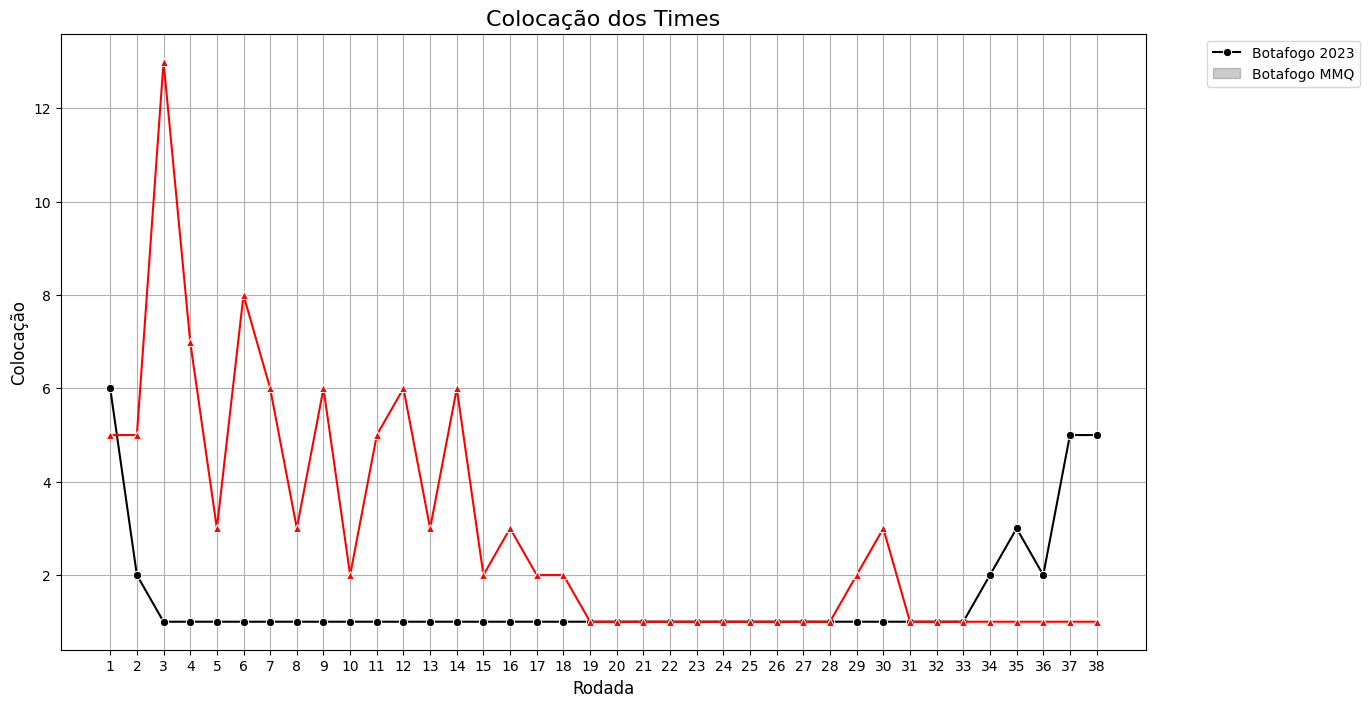

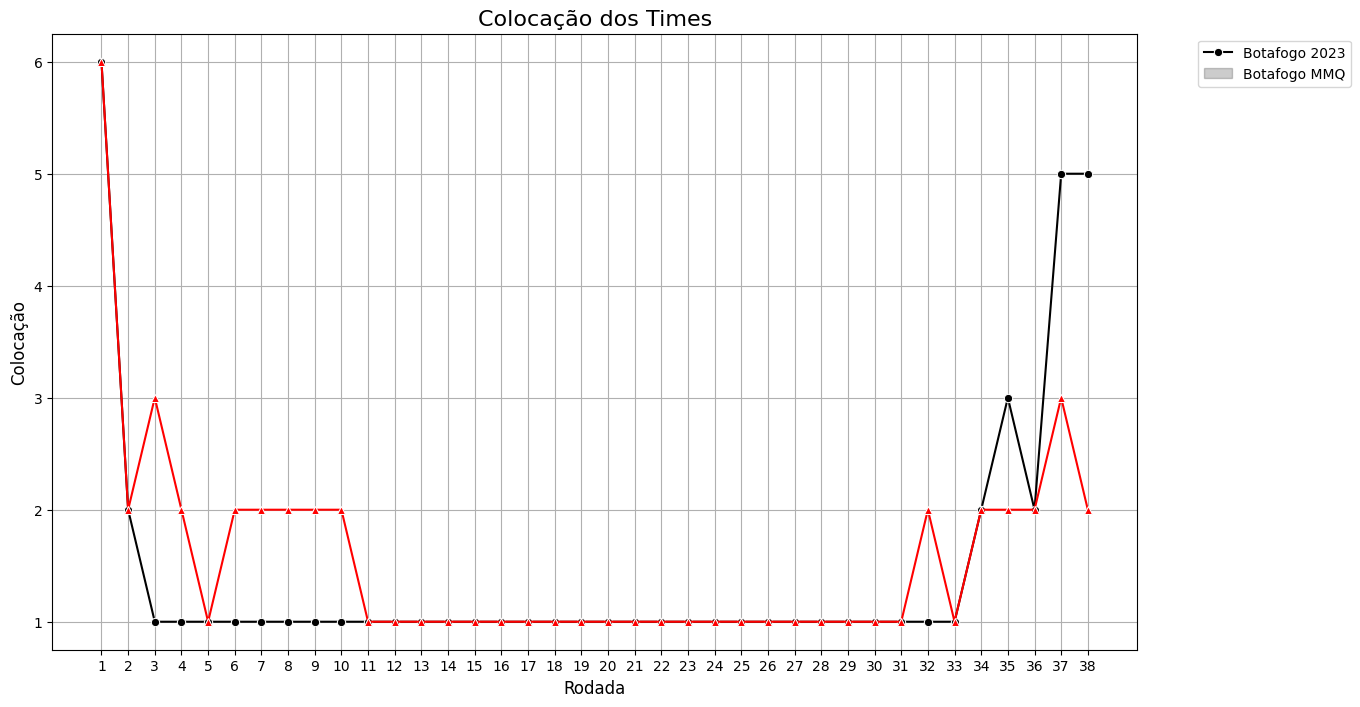

In [ ]:
plot_rodadas("Botafogo", df_ranking, rodadas_mmq(df, times, x[0],x[1], x[2], x[3]),38)
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq,38) 

In [57]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error



# 1. Agregar métricas por time para todas as rodadas
metrics = pd.concat([
    df[["time_mandante", "gols_mandante", "chutes_mandante", "valor_equipe_titular_mandante"]]
    .rename(columns={"time_mandante": "time", 
                     "gols_mandante": "gols", 
                     "chutes_mandante": "finalizacoes", 
                     "valor_equipe_titular_mandante": "valor"}),
    df[["time_visitante", "gols_visitante", "chutes_visitante", "valor_equipe_titular_visitante"]]
    .rename(columns={"time_visitante": "time", 
                     "gols_visitante": "gols", 
                     "chutes_visitante": "finalizacoes", 
                     "valor_equipe_titular_visitante": "valor"})
]).groupby("time").mean().reset_index()

# Ranking real (rodada 38)
ranking_final = pd.concat([
    df[df["rodada"] == 38][["time_mandante", "colocacao_mandante"]]
    .rename(columns={"time_mandante": "time", "colocacao_mandante": "ranking_real"}),
    df[df["rodada"] == 38][["time_visitante", "colocacao_visitante"]]
    .rename(columns={"time_visitante": "time", "colocacao_visitante": "ranking_real"})
]).drop_duplicates().reset_index(drop=True)

# Combinar métricas com ranking final
data_final = pd.merge(metrics, ranking_final, on="time")

# 2. Normalizar as variáveis explicativas
scaler = StandardScaler()
X = scaler.fit_transform(data_final[["gols", "finalizacoes", "valor"]])
y = data_final["ranking_real"].values

# 3. Testar modelos regularizados: Ridge e Lasso
ridge = Ridge(alpha=1.0)  # Regularização L2
lasso = Lasso(alpha=0.1)  # Regularização L1

ridge.fit(X, y)
lasso.fit(X, y)

x = lasso.coef_
# Exibir coeficientes dos modelos
print("Coeficientes Ridge (L2):", ridge.coef_)
print("Intercepto Ridge:", ridge.intercept_)

print("Coeficientes Lasso (L1):", lasso.coef_)
print("Intercepto Lasso:", lasso.intercept_)

# 4. Calcular predições e erros
y_pred_ridge = ridge.predict(X)
y_pred_lasso = lasso.predict(X)

mae_ridge = mean_absolute_error(y, y_pred_ridge)
mae_lasso = mean_absolute_error(y, y_pred_lasso)

print("Erro médio absoluto Ridge (MAE):", mae_ridge)
print("Erro médio absoluto Lasso (MAE):", mae_lasso)

Coeficientes Ridge (L2): [-3.49345634 -0.83160824 -1.22175621]
Intercepto Ridge: 10.500000000000002
Coeficientes Lasso (L1): [-3.70423383 -0.71954169 -1.079594  ]
Intercepto Lasso: 10.500000000000002
Erro médio absoluto Ridge (MAE): 2.5019612719018016
Erro médio absoluto Lasso (MAE): 2.470778929370864


In [127]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Função para calcular o ranking dos times com base nos pesos
def ranking_times(df, times, rodada, peso_gol_mandante=1, peso_gol_fora=1, peso_valor=0, peso_finalizacoes=0):
    pares_e_resultados = []
    df = df.fillna(0)

    # Ajustar para o número de linhas reais do DataFrame
    for i in range(len(df)):
        time_mandante = df.loc[i, 'time_mandante']
        time_visitante = df.loc[i, 'time_visitante']
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i, 'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i, 'chutes_mandante']
        finalizacoes_visitante = df.loc[i, 'chutes_visitante']

        # Calcular o resultado ajustado pelos pesos
        resultado = ((gols_mandante * peso_gol_mandante) - (gols_visitante * peso_gol_fora)) + \
                    (peso_valor * (valor_mandante - valor_visitante)) + \
                    peso_finalizacoes * (finalizacoes_mandante - finalizacoes_visitante)
        
        pares_e_resultados.append((time_mandante, time_visitante, resultado))

    num_times = len(times)
    num_equacoes = len(pares_e_resultados)
    A = np.zeros((num_equacoes, num_times))
    b = np.zeros(num_equacoes)

    for i, (time1, time2, resultado) in enumerate(pares_e_resultados):
        indice1 = times[time1]
        indice2 = times[time2]
        
        A[i, indice1] = 1
        A[i, indice2] = -1
        b[i] = resultado

    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    indice_para_times = {indice: nome for nome, indice in times.items()}

    # Combine os valores de `x` com os nomes dos times
    times_valores = [(indice_para_times[i], x[i]) for i in range(len(x))]

    # Ordene a lista pelo valor de `x`
    times_valores_ordenados = sorted(times_valores, key=lambda item: item[1], reverse=True)

    return times_valores_ordenados

# Função de custo para otimizar os pesos
def otimizar_pesos(pesos, df, times, rodada, ranking_real):
    peso_gol_mandante, peso_gol_fora, peso_valor, peso_finalizacoes = pesos
    ranking_previsto = ranking_times(
        df, times, rodada,
        peso_gol_mandante=peso_gol_mandante,
        peso_gol_fora=peso_gol_fora,
        peso_valor=peso_valor,
        peso_finalizacoes=peso_finalizacoes
    )
    
    # Extrair somente os nomes dos times na ordem do ranking previsto
    ranking_previsto_times = [time for time, _ in ranking_previsto]
    
    # Calcular soma das diferenças absolutas entre posições
    erro = 0
    for time, pos_real in ranking_real.items():
        pos_previsto = ranking_previsto_times.index(time) + 1
        erro += abs(pos_real - pos_previsto)
    
    return erro


# Criar o dicionário com o ranking real
ranking_real = {
    "Palmeiras": 1,
    "Grêmio": 2,
    "Atlético-MG": 3,
    "Flamengo": 4,
    "Botafogo": 5,
    "RB Bragantino": 6,
    "Fluminense": 7,
    "Athletico-PR": 8,
    "Internacional": 9,
    "Fortaleza": 10,
    "São Paulo": 11,
    "Cuiabá-MT": 12,
    "Corinthians": 13,
    "Cruzeiro": 14,
    "Vasco da Gama": 15,
    "EC Bahia": 16,
    "Santos": 17,
    "Goiás": 18,
    "Coritiba FC": 19,
    "América-MG": 20
}

# Otimizar os pesos
pesos_iniciais = [1, 1, 0, 0]  # Pesos iniciais para as variáveis
resultado = minimize(otimizar_pesos, pesos_iniciais, args=(df, times, 38, ranking_real), method="Nelder-Mead")

# Pesos ótimos
pesos_otimos = resultado.x
print("Pesos Ótimos:", pesos_otimos)

# Erro final
erro_final = otimizar_pesos(pesos_otimos, df, times, 38, ranking_real)
print("Erro Final:", erro_final)


Pesos Ótimos: [1.   1.05 0.   0.  ]
Erro Final: 28


In [88]:
# Transformando o DataFrame para ter os times como linhas
rodadas = []
gols = []
faltas = []
valor_mercado = []

times = pd.unique(df[['time_mandante', 'time_visitante']].values.ravel('K'))

for time in times:
    df_time_mandante = df[df['time_mandante'] == time]
    df_time_visitante = df[df['time_visitante'] == time]

    total_rodadas = len(df_time_mandante) + len(df_time_visitante)
    total_gols = df_time_mandante['gols_mandante'].sum() + df_time_visitante['gols_visitante'].sum()
    total_faltas = df_time_mandante['chutes_mandante'].sum() + df_time_visitante['chutes_visitante'].sum()
    total_valor_mercado = (
        df_time_mandante['valor_equipe_titular_mandante'].sum() + df_time_visitante['valor_equipe_titular_visitante'].sum()
    )

    rodadas.append(total_rodadas)
    gols.append(total_gols)
    faltas.append(total_faltas)
    valor_mercado.append(total_valor_mercado)

df_times = pd.DataFrame({
    'time': times,
    'rodadas': rodadas,
    'gols': gols,
    'chutes': faltas,
    'valor_mercado': valor_mercado
})

# Filtrar as colocações dos times na rodada 38
rodada_38 = df_ranking[df_ranking['rodada'] == 38]

# Criar um dicionário de colocação para os times com base na rodada 38
colocacao_times = rodada_38.set_index('time')['colocacao'].to_dict()

# Atualizar o DataFrame df_times com as colocações da rodada 38
df_times['colocacao_rodada_38'] = df_times['time'].map(colocacao_times)


In [89]:
df_times

,time,rodadas,gols,chutes,valor_mercado,colocacao_rodada_38
0,Athletico-PR,38,51.0,554.0,155340.0,8.0
1,Flamengo,38,56.0,482.0,321375.0,4.0
2,Palmeiras,38,64.0,597.0,297345.0,1.0
3,Atlético-MG,38,52.0,487.0,172365.0,3.0
4,Grêmio,38,63.0,509.0,109165.0,2.0
5,Fortaleza,38,45.0,538.0,49770.0,10.0
6,Botafogo,38,58.0,523.0,97510.0,5.0
7,Corinthians,38,47.0,462.0,159525.0,13.0
8,RB Bragantino,38,49.0,638.0,119721.0,6.0
9,América-MG,38,42.0,500.0,32496.0,20.0


In [91]:
A = df_times[['gols', 'chutes', 'valor_mercado']].values
b = df_times['colocacao_rodada_38'].values
A,b

(array([[5.10000e+01, 5.54000e+02, 1.55340e+05],
        [5.60000e+01, 4.82000e+02, 3.21375e+05],
        [6.40000e+01, 5.97000e+02, 2.97345e+05],
        [5.20000e+01, 4.87000e+02, 1.72365e+05],
        [6.30000e+01, 5.09000e+02, 1.09165e+05],
        [4.50000e+01, 5.38000e+02, 4.97700e+04],
        [5.80000e+01, 5.23000e+02, 9.75100e+04],
        [4.70000e+01, 4.62000e+02, 1.59525e+05],
        [4.90000e+01, 6.38000e+02, 1.19721e+05],
        [4.20000e+01, 5.00000e+02, 3.24960e+04],
        [4.10000e+01, 4.29000e+02, 6.24350e+04],
        [3.90000e+01, 4.69000e+02, 1.34740e+05],
        [4.10000e+01, 4.78000e+02, 1.22430e+05],
        [5.10000e+01, 5.53000e+02, 1.44110e+05],
        [4.00000e+01, 5.19000e+02, 1.14395e+05],
        [3.50000e+01, 5.28000e+02, 7.80900e+04],
        [5.00000e+01, 5.38000e+02, 9.31700e+04],
        [4.00000e+01, 4.49000e+02, 3.09820e+04],
        [4.60000e+01, 4.62000e+02, 1.35585e+05],
        [3.60000e+01, 4.96000e+02, 3.81690e+04]]),
 array([ 8.,  4., 

In [92]:
x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

In [115]:
import numpy as np

# Configurações iniciais
def ponto_fixo(erro_ranking, rodadas_mmq, df, df2, times, x0, tol=1e-6, max_iter=100):
    """
    Método do ponto fixo para ajustar os parâmetros x1, x2, x3, x4.
    
    Parâmetros:
        erro_ranking: Função para calcular o erro de ranking.
        rodadas_mmq: Função para rodar o cálculo do MMQ.
        df: DataFrame com os dados.
        times: Lista de times.
        x0: Array inicial [x1, x2, x3, x4].
        tol: Tolerância para o critério de parada.
        max_iter: Número máximo de iterações.
        
    Retorna:
        x: Parâmetros ajustados [x1, x2, x3, x4].
        erro: Último erro calculado.
    """
    x = np.array(x0)  # Inicializa com os valores iniciais
    for i in range(max_iter):
        # Calcula o próximo valor (transformação de x)
        # Essa transformação será g(x) baseada na lógica do problema
        novo_x = np.array([
            # Aqui você define g(x) para cada variável
            x[0] - 0.1 * erro_ranking(df, rodadas_mmq(df2, times, x[0], x[1], x[2], x[3])),
            x[1] - 0.1 * erro_ranking(df, rodadas_mmq(df2, times, x[0], x[1], x[2], x[3])),
            x[2] - 0.1 * erro_ranking(df, rodadas_mmq(df2, times, x[0], x[1], x[2], x[3])),
            x[3] - 0.1 * erro_ranking(df, rodadas_mmq(df2, times, x[0], x[1], x[2], x[3]))
        ])
        
        # Critério de parada
        if np.linalg.norm(novo_x - x) < tol:
            break
        
        x = novo_x  # Atualiza x para a próxima iteração
    
    erro = erro_ranking(df, rodadas_mmq(df2, times, x[0], x[1], x[2], x[3]))
    return x, erro

In [116]:
# Valores iniciais para x1, x2, x3, x4
x0 = [1.0, 1.0, 0, 0]

# Chamando o método do ponto fixo
x_ajustado, erro_final = ponto_fixo(erro_ranking, rodadas_mmq, df_ranking, df,  times, x0)

print("Parâmetros ajustados:", x_ajustado)
print("Erro final:", erro_final)


Parâmetros ajustados: [-61203.6 -61203.6 -61204.6 -61204.6]
Erro final: 6170.0


In [111]:
df_ranking

,rodada,time,colocacao
0,1,Fluminense,1.0
1,1,Flamengo,2.0
2,1,Athletico-PR,3.0
3,1,Palmeiras,4.0
4,1,RB Bragantino,5.0
...,...,...,...
755,38,EC Bahia,16.0
756,38,Santos,17.0
757,38,Goiás,18.0
758,38,Coritiba FC,19.0


In [171]:
from scipy.optimize import minimize

# Função de perda
def funcao_perda(pesos, df, times, rodada, ranking_real):
    ranking_previsto = rodadas_mmq(df, times, *pesos)
    erro = ((ranking_real.values - np.array(ranking_previsto)) ** 2).sum()
    return erro

# Pesos iniciais
pesos_iniciais = [1, 1.2, 0, 0]

# Otimização
resultado = minimize(
    otimizar_pesos,
    pesos_iniciais,
    args=(df, times, 38, ranking_real),
    method='BFGS'  # Método baseado em gradientes
)




x = resultado.x
print("Pesos Otimizados:", x)
print("ORIGINAL")
print(erro_ranking_rodada(df_ranking, df_ranking_mmq,38))
print(erro_ranking(df_ranking, df_ranking_mmq))
print("GRADIENTE")
print(erro_ranking_rodada(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3]), 38))
print(erro_ranking(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3])))


Pesos Otimizados: [1.  1.2 0.  0. ]
ORIGINAL
32.0
1216.0
GRADIENTE
26.0
1550.0


In [185]:
df_aux = rodadas_mmq(df, times, x[0],x[1], x[2], x[3])
display(df_aux[df_aux['rodada'] == 38])
display(df_ranking_mmq[df_ranking_mmq['rodada'] == 38])

,rodada,time,colocacao
740,38,Palmeiras,1
741,38,Botafogo,2
742,38,Atlético-MG,3
743,38,Flamengo,4
744,38,RB Bragantino,5
745,38,Grêmio,6
746,38,Athletico-PR,7
747,38,Fluminense,8
748,38,Cruzeiro,9
749,38,São Paulo,10


,rodada,time,colocacao
740,38,Palmeiras,1
741,38,Botafogo,2
742,38,Atlético-MG,3
743,38,RB Bragantino,4
744,38,Flamengo,5
745,38,Athletico-PR,6
746,38,Grêmio,7
747,38,Fluminense,8
748,38,Cruzeiro,9
749,38,São Paulo,10


In [200]:
times2022 = {
    "Athletico-PR": 0,
    "Goiás": 1,
    "Ceará SC": 2,
    "Santos": 3,
    "Flamengo": 4,
    "Coritiba FC": 5,
    "Palmeiras": 6,
    "Cuiabá-MT": 7,
    "Corinthians": 8,
    "Atlético-GO": 9,
    "Botafogo": 10,
    "São Paulo": 11,
    "RB Bragantino": 12,
    "Juventude": 13,
    "Fortaleza": 14,
    "Internacional": 15,
    "Atlético-MG": 16,
    "Avaí FC": 17,
    "América-MG": 18,
    "Fluminense": 19
}

df_mandantes = df1[df1['ano_campeonato']==2022].reset_index(drop=True)[['rodada', 'time_mandante', 'colocacao_mandante']].rename(
    columns={'time_mandante': 'time', 'colocacao_mandante': 'colocacao'}
)
df_visitantes = df1[df1['ano_campeonato']==2022].reset_index(drop=True)[['rodada', 'time_visitante', 'colocacao_visitante']].rename(
    columns={'time_visitante': 'time', 'colocacao_visitante': 'colocacao'}
)
df_ranking_2022 = pd.concat([df_mandantes, df_visitantes], ignore_index=True)
df_ranking_2022 = df_ranking_2022.sort_values(by=['rodada', 'colocacao']).reset_index(drop=True)

df_aux_2022 = rodadas_mmq(df1[df1['ano_campeonato']==2022].reset_index(drop=True), times2022, x[0],x[1], x[2], x[3])
df_mmq_2022 = rodadas_mmq(df1[df1['ano_campeonato']==2022].reset_index(drop=True), times2022)

In [201]:
display(erro_ranking(df_ranking_2022, df_aux_2022))
display(erro_ranking(df_ranking_2022, df_mmq_2022))

2662.0

2626.0

## K-MEANS

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [228]:
# Criando dataframe dos mandantes
df_mandantes = df[
    [
        'time_mandante',
        'gols_mandante',
        'escanteios_mandante',
        'faltas_mandante',
        'chutes_bola_parada_mandante',
        'defesas_mandante',
        'impedimentos_mandante',
        'chutes_mandante',
        'chutes_fora_mandante'
    ]
].rename(
    columns={
        'time_mandante': 'time',
        'gols_mandante': 'gols',
        'escanteios_mandante': 'escanteios',
        'faltas_mandante': 'faltas',
        'chutes_bola_parada_mandante': 'chutes_bola_parada',
        'defesas_mandante': 'defesas',
        'impedimentos_mandante': 'impedimentos',
        'chutes_mandante': 'chutes',
        'chutes_fora_mandante': 'chutes_fora'
    }
)

# Criando dataframe dos visitantes
df_visitantes = df[
    [
        'time_visitante',
        'gols_visitante',
        'escanteios_visitante',
        'faltas_visitante',
        'chutes_bola_parada_visitante',
        'defesas_visitante',
        'impedimentos_visitante',
        'chutes_visitante',
        'chutes_fora_visitante'
    ]
].rename(
    columns={
        'time_visitante': 'time',
        'gols_visitante': 'gols',
        'escanteios_visitante': 'escanteios',
        'faltas_visitante': 'faltas',
        'chutes_bola_parada_visitante': 'chutes_bola_parada',
        'defesas_visitante': 'defesas',
        'impedimentos_visitante': 'impedimentos',
        'chutes_visitante': 'chutes',
        'chutes_fora_visitante': 'chutes_fora'
    }
)

df_ranking_2023 = pd.concat([df_mandantes, df_visitantes], ignore_index=True)
df_medias = df_ranking_2023.groupby('time').mean().reset_index()
df_medias


,time,gols,escanteios,faltas,chutes_bola_parada,defesas,impedimentos,chutes,chutes_fora
0,América-MG,1.105263,4.459459,14.540541,12.189189,3.540541,1.540541,13.513514,5.810811
1,Athletico-PR,1.342105,5.710526,15.263158,13.263158,3.368421,1.763158,14.578947,6.394737
2,Atlético-MG,1.368421,4.947368,15.763158,12.526316,2.894737,1.605263,12.815789,4.921053
3,Botafogo,1.526316,4.578947,13.552632,12.868421,3.526316,1.078947,13.763158,5.236842
4,Corinthians,1.236842,4.394737,12.500000,13.394737,3.684211,1.447368,12.157895,4.947368
5,Coritiba FC,1.078947,4.342105,15.421053,13.973684,3.947368,1.631579,11.289474,4.763158
6,Cruzeiro,0.921053,6.315789,15.000000,12.394737,2.894737,1.842105,13.894737,6.263158
7,Cuiabá-MT,1.052632,4.921053,12.421053,14.789474,3.000000,2.026316,11.815789,4.842105
8,EC Bahia,1.315789,5.500000,14.447368,13.473684,3.684211,1.421053,14.157895,6.000000
9,Flamengo,1.473684,5.270270,13.108108,13.702703,3.594595,1.243243,13.027027,4.648649


In [237]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_medias.drop(columns=['time']))

df_medias['cluster'] = kmeans.labels_

In [238]:
import plotly.express as px
from sklearn.decomposition import PCA

# Reduzir os dados para 3 dimensões
pca = PCA(n_components=3)
reduced_data_3d = pca.fit_transform(df_medias.drop(columns=['time', 'cluster']))

# Criar um DataFrame com os dados reduzidos
df_plot = pd.DataFrame(reduced_data_3d, columns=['Componente 1', 'Componente 2', 'Componente 3'])
df_plot['time'] = df_medias['time']
df_plot['cluster'] = df_medias['cluster']

# Criar o gráfico 3D interativo
fig = px.scatter_3d(
    df_plot, 
    x='Componente 1', 
    y='Componente 2', 
    z='Componente 3', 
    color='cluster',  # Diferenciar clusters por cor
    text='time',      # Adicionar rótulos com o nome dos times
    title="Clusters dos Times em 3D"
)

# Mostrar o gráfico
fig.show()
